In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yJtsaAZJmqSJl0BrhxDN")
project = rf.workspace("errai-zca9d").project("guitar-parts-detection")
version = project.version(1)
dataset = version.download("yolov8")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Guitar-Parts-Detection-1 in yolov8:: 100%|██████████| 2264/2264 [00:00<00:00, 6417.86it/s]


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.4 MB/s eta 0:00:00


# Эксперименты по обучению и оценке моделей

### YOLOv8s-obb

Первый эксперимент. Берем маленькую модель YOLO той же версии, что и в статье TapToTab

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s-obb.pt')

results = model.train(
    data="/content/Guitar-Parts-Detection-1/data.yaml",
    epochs=70,
    imgsz=640,
    batch=8,
    device=0,
    patience=10,

    fliplr=0.5,       # зеркальный ракурс
    degrees=15.0,     # наклон гитары в кадре
    hsv_h=0.10,       # различия цвета грифа и каподастров
    hsv_v=0.30        # освещение сцены
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Guitar-Parts-Detection-1/data.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.1, hsv_s=0.7, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

def analyze_training_results(res_csv):
    """Визуализация результатов обучения"""

    results_csv = Path(res_csv)

    if not results_csv.exists():
        print("Файл results.csv не найден!")
        print("Доступные файлы:")
        train_dir = Path("runs/obb/train")
        if train_dir.exists():
            for file in train_dir.iterdir():
                print(f"   {file.name}")
        return

    try:
        df = pd.read_csv(results_csv)
        print(f"Загружено {len(df)} записей из CSV")
        print(f"Доступные колонки: {list(df.columns)}")
    except Exception as e:
        print(f"Ошибка загрузки CSV: {e}")
        return

    # Графики
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Список графиков для построения
    plots = [
        {'data': ['train/box_loss', 'val/box_loss'],
         'title': 'Box Loss', 'labels': ['Train', 'Val']},
        {'data': ['train/cls_loss', 'val/cls_loss'],
         'title': 'Classification Loss', 'labels': ['Train', 'Val']},
        {'data': ['metrics/mAP50(B)'],
         'title': 'mAP50', 'labels': ['mAP50']},
        {'data': ['metrics/precision(B)'],
         'title': 'Precision', 'labels': ['Precision']},
        {'data': ['metrics/recall(B)'],
         'title': 'Recall', 'labels': ['Recall']},
        {'data': ['metrics/mAP50-95(B)'],
         'title': 'mAP50-95', 'labels': ['mAP50-95']}
    ]

    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

    for i, plot_info in enumerate(plots):
        if i < len(axes):
            ax = axes[i]
            for j, col in enumerate(plot_info['data']):
                if col in df.columns:
                    # Заменяем NaN значения
                    data = df[col].fillna(method='ffill')
                    if len(data) > 0:
                        label = plot_info['labels'][j] if j < len(plot_info['labels']) else col
                        ax.plot(data, label=label, color=colors[j % len(colors)], linewidth=2)

            ax.set_title(plot_info['title'], fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()

    plt.tight_layout()
    plt.show()

    print("\nФинальные метрики обучения:")
    metrics = {
        'metrics/mAP50(B)': 'mAP50',
        'metrics/mAP50-95(B)': 'mAP50-95',
        'metrics/precision(B)': 'Precision',
        'metrics/recall(B)': 'Recall',
        'val/box_loss': 'Val Box Loss',
        'train/box_loss': 'Train Box Loss'
    }

    for col, name in metrics.items():
        if col in df.columns:
            # Берем последнее не-NaN значение
            clean_data = df[col].dropna()
            if len(clean_data) > 0:
                final_value = clean_data.iloc[-1]
                print(f"   {name}: {final_value:.4f}")

Загружено 70 записей из CSV
Доступные колонки: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


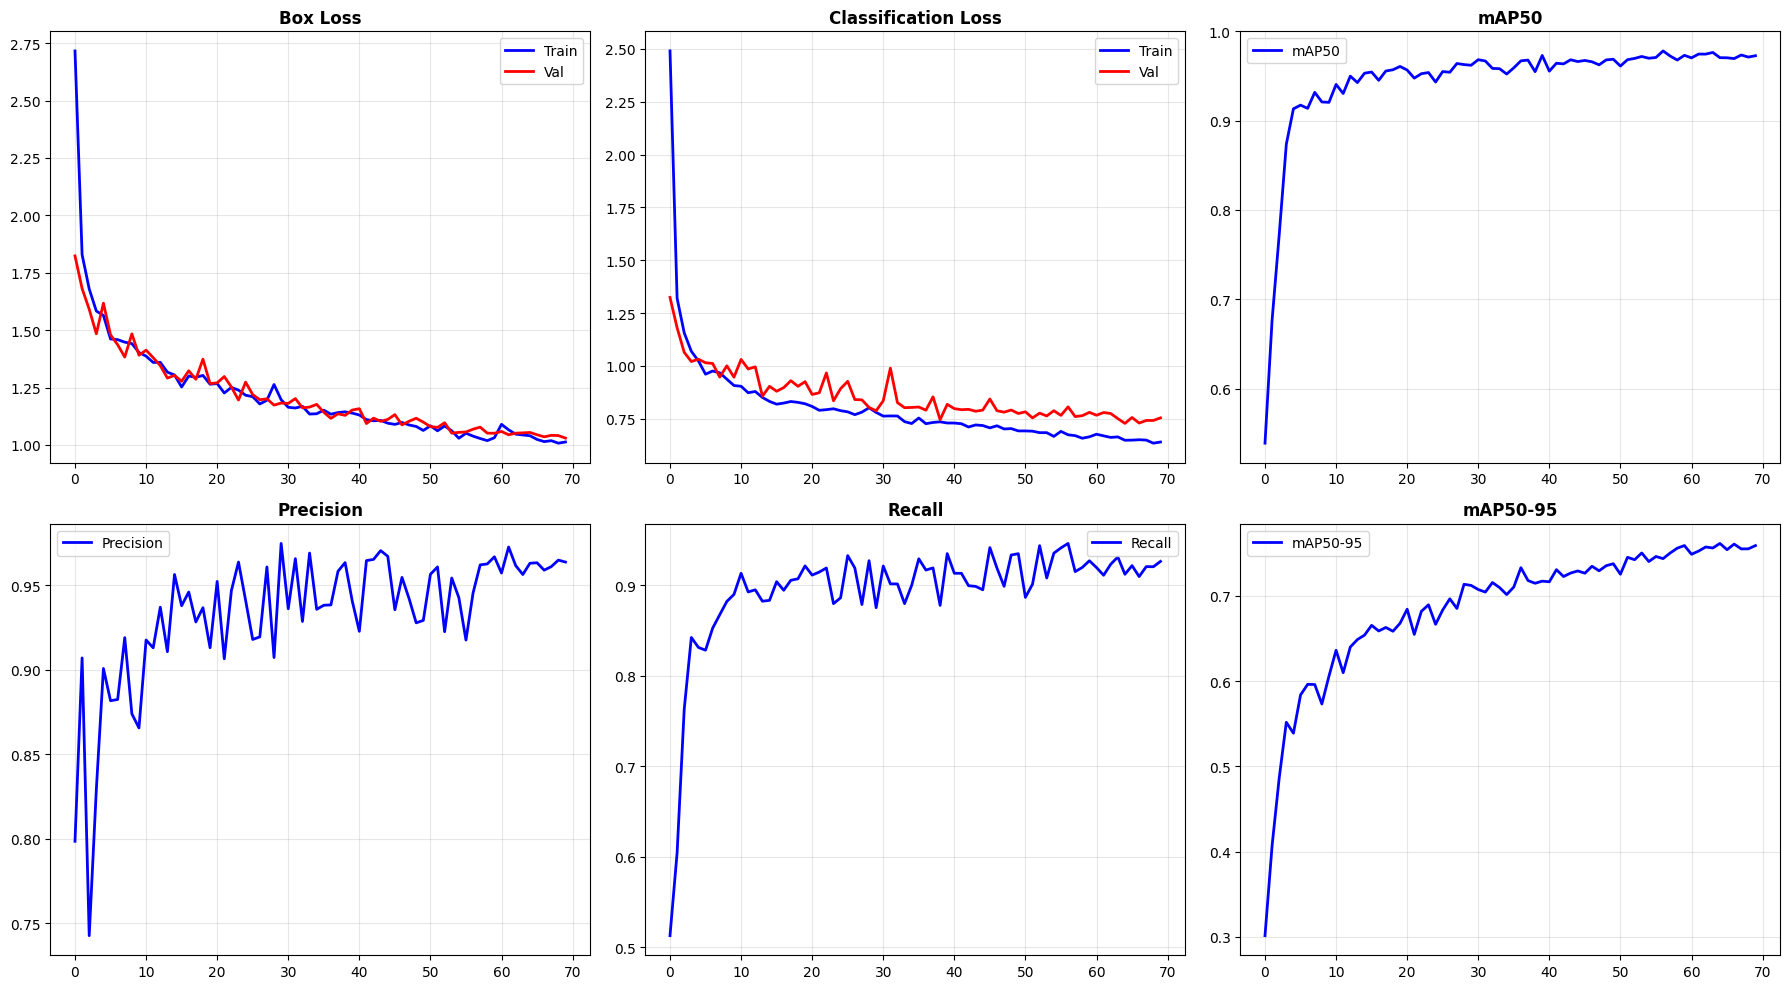


Финальные метрики обучения:
   mAP50: 0.9728
   mAP50-95: 0.7590
   Precision: 0.9638
   Recall: 0.9264
   Val Box Loss: 1.0297
   Train Box Loss: 1.0129


In [ ]:
analyze_training_results("/content/runs/obb/train2/results.csv")

In [3]:
from ultralytics import YOLO

Метрики на тестовой выборке:

In [7]:
model = YOLO('/content/sample_data/yolov8s-obb_d.pt')
model.val(data="/content/Guitar-Parts-Detection-1/data.yaml", split="test")

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-obb summary (fused): 81 layers, 11,413,119 parameters, 0 gradients, 29.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1708.5±617.9 MB/s, size: 51.2 KB)
val: Scanning /content/Guitar-Parts-Detection-1/test/labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 162/162 359.9Kit/s 0.0s
val: /content/Guitar-Parts-Detection-1/test/images/frame_022_jpg.rf.3198116994bc728b17dc4e0d7b2ae2f7.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_051_jpg.rf.baf2e3c0ffb84189ff05333a0ecfd075.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_096_jpg.rf.bc59c51129e1559041eb9b767ea81d27.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_152_jpg.rf.8301e22c37c5f07065a00af1ce6ed901.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/guitar-182-_j

ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdb6030e450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

### YOLO11s-obb

Второй эксперимент по обучению модели, но уже наиболее актуальной версии. Размер модели тот же, как и гиперпараметры и аугментации.

In [ ]:
from ultralytics import YOLO

model_11s = YOLO('yolo11s-obb.pt')

results_11s = model_11s.train(
    data="/content/Guitar-Parts-Detection-1/data.yaml",
    epochs=70,
    imgsz=640,
    batch=8,
    device=0,
    patience=15,

    fliplr=0.5,        # зеркальные ракурсы
    degrees=15.0,     # наклон гитары в кадре
    hsv_h=0.10,       # различия цвета грифа и каподастров
    hsv_v=0.30        # освещение сцены
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Guitar-Parts-Detection-1/data.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.1, hsv_s=0.7, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots

Загружено 70 записей из CSV
Доступные колонки: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


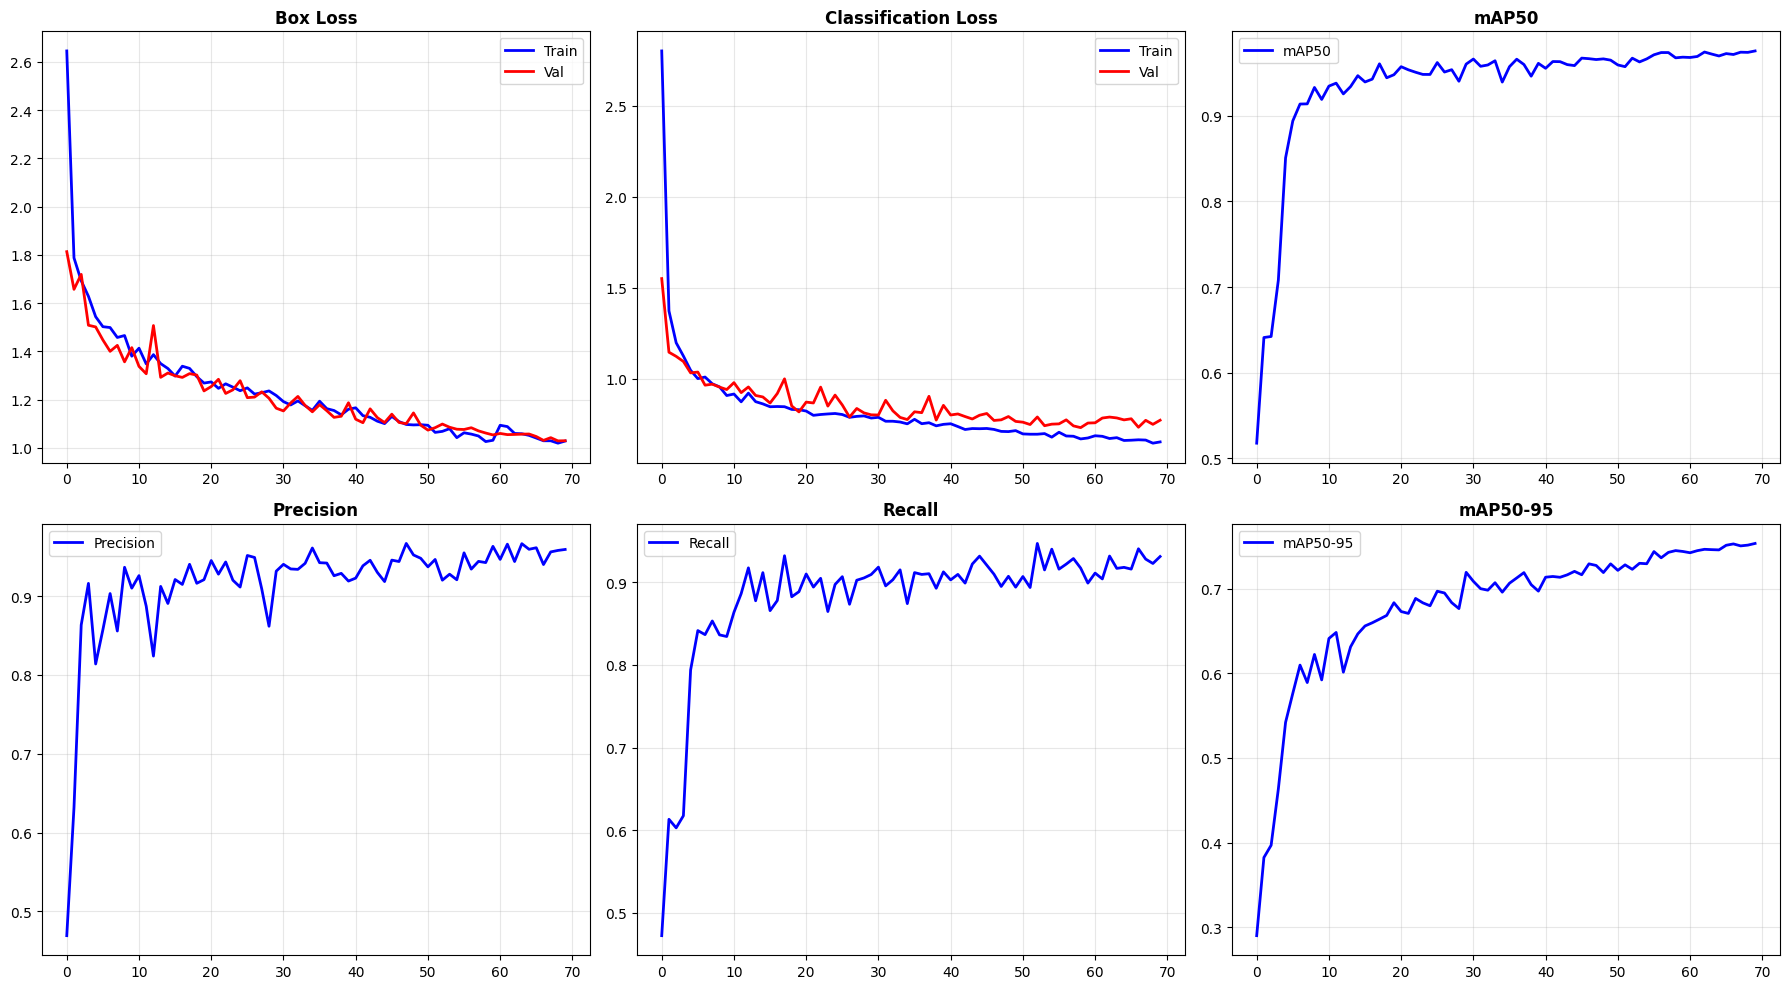


Финальные метрики обучения:
   mAP50: 0.9757
   mAP50-95: 0.7535
   Precision: 0.9592
   Recall: 0.9312
   Val Box Loss: 1.0294
   Train Box Loss: 1.0281


In [ ]:
analyze_training_results("/content/runs/obb/train/results.csv")

Метрики на тестовой выборке:

In [ ]:
model_11s.val(data="/content/Guitar-Parts-Detection-1/data.yaml", split="test")

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-obb summary (fused): 109 layers, 9,700,335 parameters, 0 gradients, 22.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1269.0±575.2 MB/s, size: 49.7 KB)
val: Scanning /content/Guitar-Parts-Detection-1/test/labels... 162 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 162/162 1.3Kit/s 0.1s
val: /content/Guitar-Parts-Detection-1/test/images/frame_022_jpg.rf.3198116994bc728b17dc4e0d7b2ae2f7.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_051_jpg.rf.baf2e3c0ffb84189ff05333a0ecfd075.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_096_jpg.rf.bc59c51129e1559041eb9b767ea81d27.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_152_jpg.rf.8301e22c37c5f07065a00af1ce6ed901.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/guitar-182-_jpg.rf.19

ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c63b60b23c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

### YOLOv8m-obb

In [ ]:
model_v8m = YOLO('yolov8m-obb.pt')

results_v8m = model_v8m.train(
    data="/content/Guitar-Parts-Detection-1/data.yaml",
    epochs=70,
    imgsz=640,
    batch=8,
    device=0,
    patience=15,

    fliplr=0.5,        # зеркальные ракурсы
    degrees=15.0,     # наклон гитары в кадре
    hsv_h=0.10,       # различия цвета грифа и каподастров
    hsv_v=0.30        # освещение сцены
)

New https://pypi.org/project/ultralytics/8.3.248 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Guitar-Parts-Detection-1/data.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.1, hsv_s=0.7, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=Fa

Загружено 70 записей из CSV
Доступные колонки: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


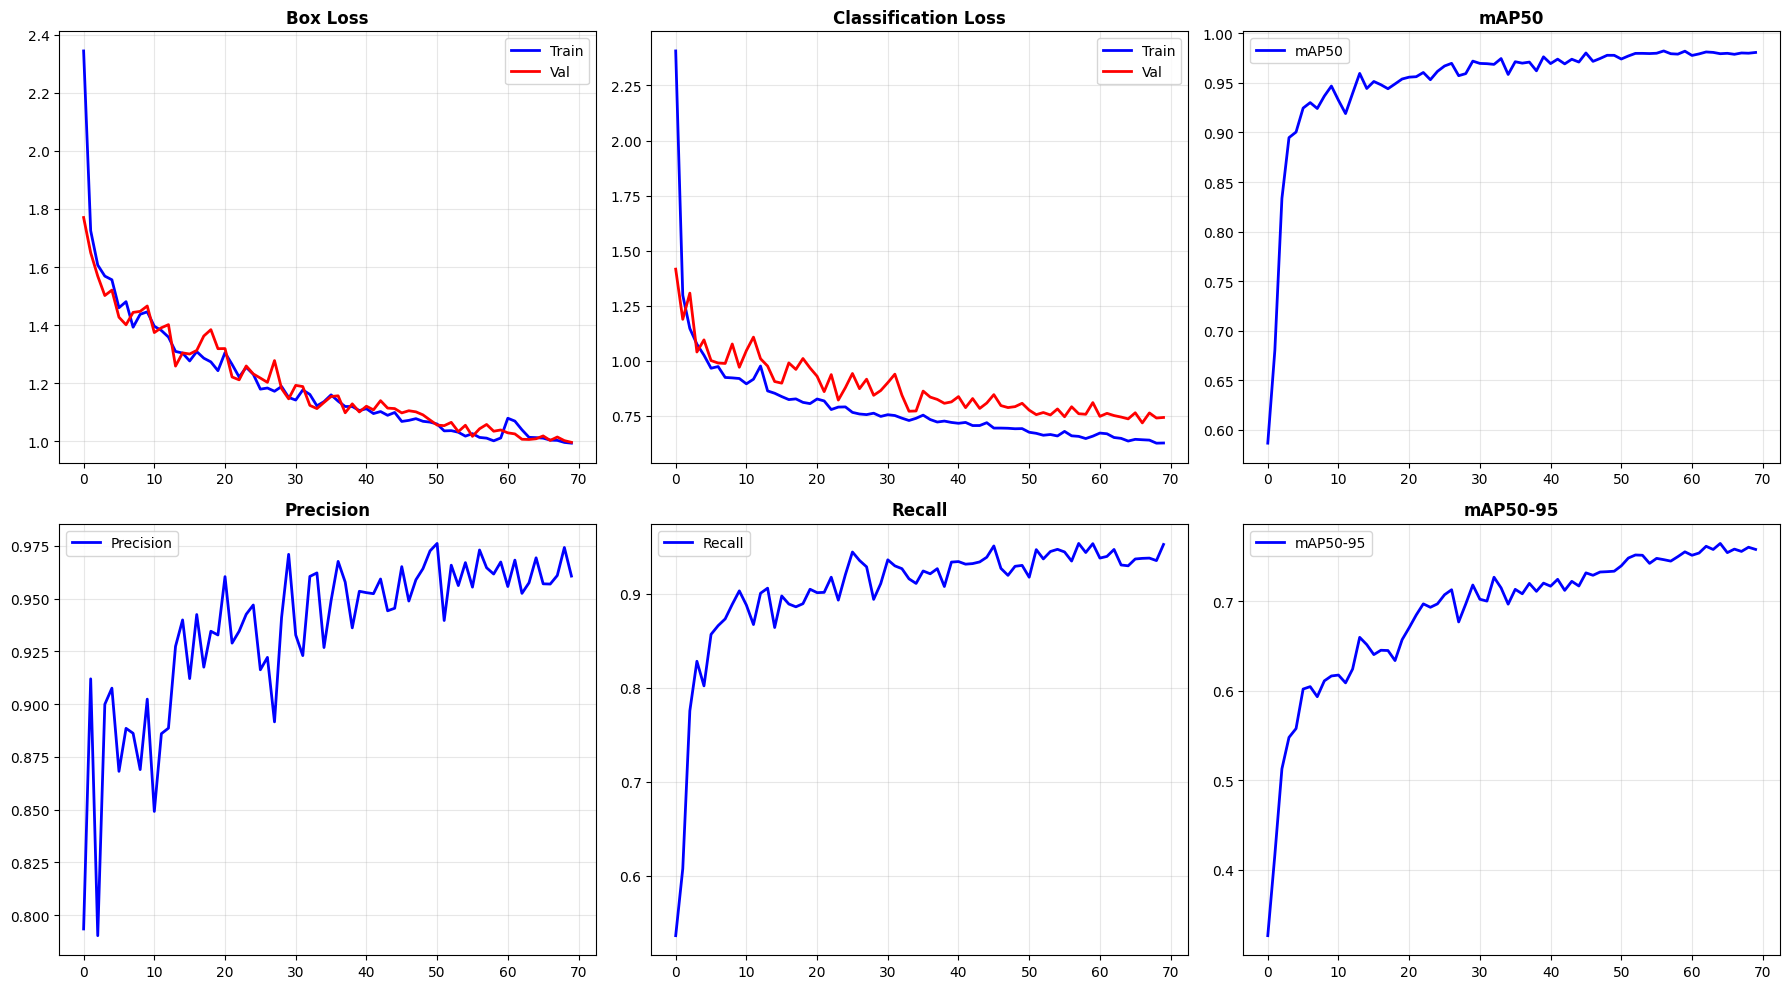


Финальные метрики обучения:
   mAP50: 0.9807
   mAP50-95: 0.7581
   Precision: 0.9607
   Recall: 0.9526
   Val Box Loss: 0.9967
   Train Box Loss: 0.9938


In [ ]:
analyze_training_results("/content/runs/obb/train3/results.csv")

Метрики на тестовой выборке:

In [8]:
model = YOLO('/content/sample_data/yolov8m-obb_d.pt')
model.val(data="/content/Guitar-Parts-Detection-1/data.yaml", split="test")

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-obb summary (fused): 101 layers, 26,402,383 parameters, 0 gradients, 80.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1306.8±359.1 MB/s, size: 42.5 KB)
val: Scanning /content/Guitar-Parts-Detection-1/test/labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 162/162 215.6Kit/s 0.0s
val: /content/Guitar-Parts-Detection-1/test/images/frame_022_jpg.rf.3198116994bc728b17dc4e0d7b2ae2f7.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_051_jpg.rf.baf2e3c0ffb84189ff05333a0ecfd075.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_096_jpg.rf.bc59c51129e1559041eb9b767ea81d27.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_152_jpg.rf.8301e22c37c5f07065a00af1ce6ed901.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/guitar-182-_

ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdb601cec00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

### YOLO11m-obb

In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model_11m = YOLO('yolo11m-obb.pt')

results_11m = model_11m.train(
    data="/content/Guitar-Parts-Detection-1/data.yaml",
    epochs=70,
    imgsz=640,
    batch=8,
    device=0,
    patience=15,

    fliplr=0.5,        # зеркальные ракурсы
    degrees=15.0,     # наклон гитары в кадре
    hsv_h=0.10,       # различия цвета грифа и каподастров
    hsv_v=0.30        # освещение сцены
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Guitar-Parts-Detection-1/data.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.1, hsv_s=0.7, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots

Загружено 70 записей из CSV
Доступные колонки: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


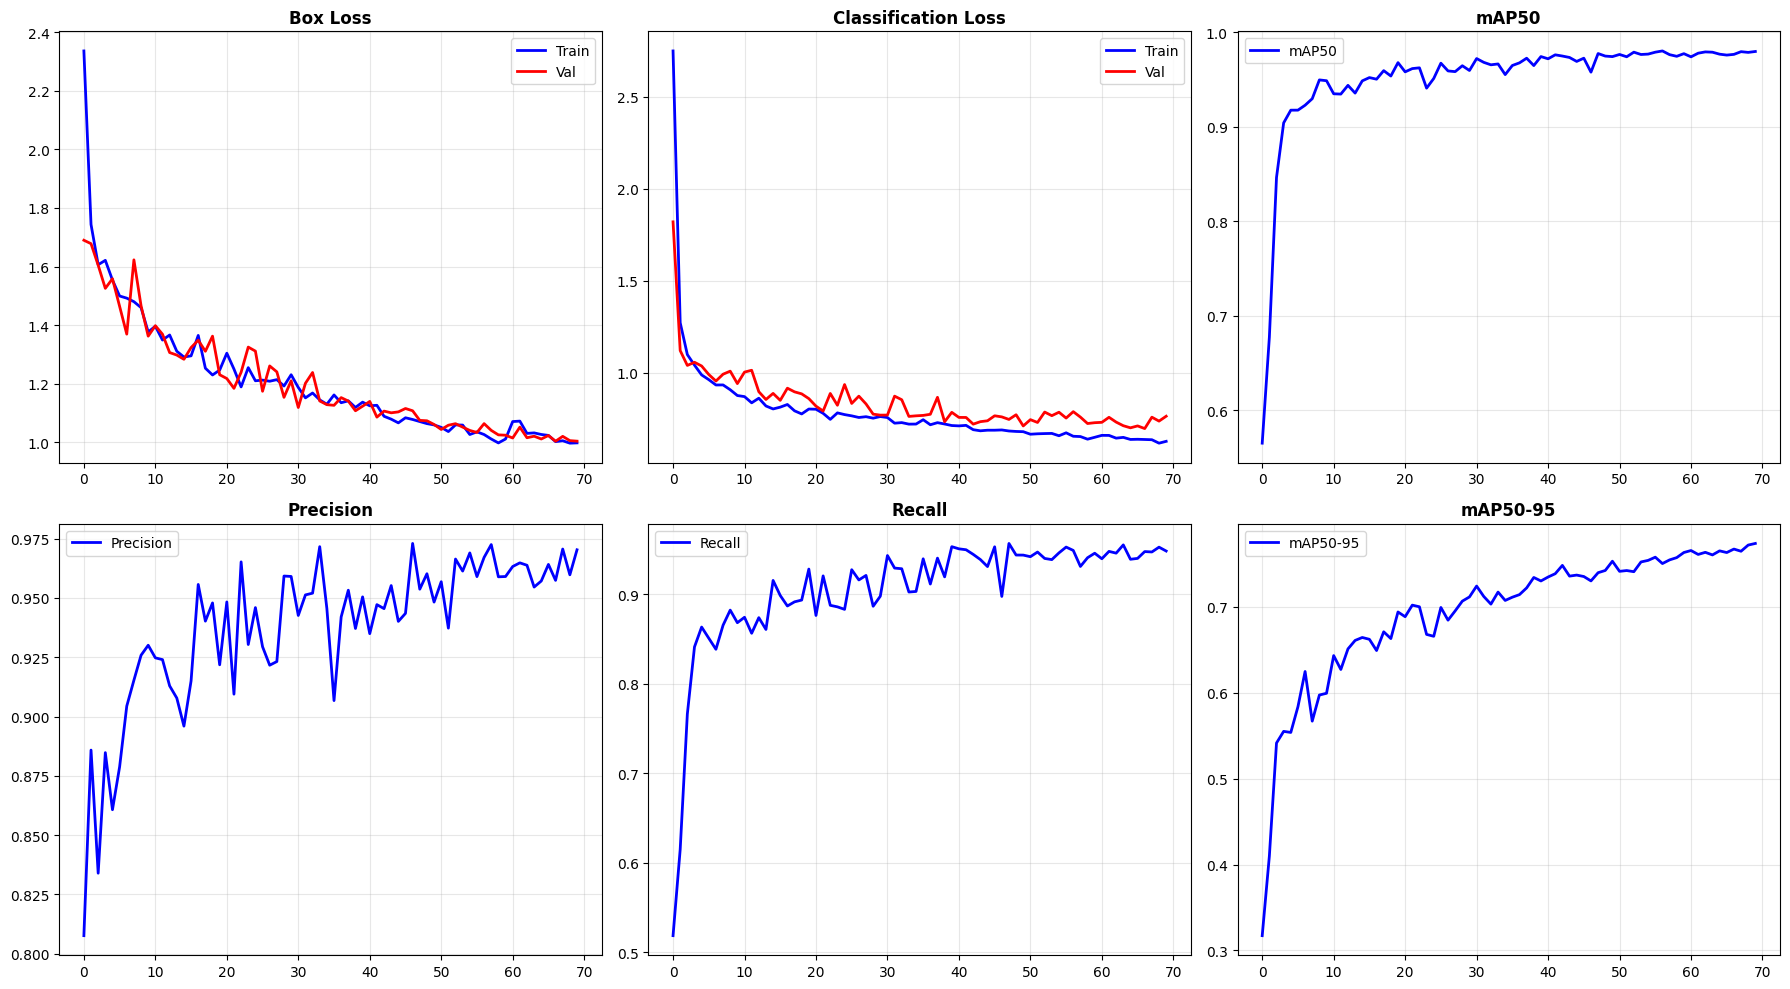


Финальные метрики обучения:
   mAP50: 0.9795
   mAP50-95: 0.7740
   Precision: 0.9703
   Recall: 0.9481
   Val Box Loss: 1.0041
   Train Box Loss: 0.9982


In [ ]:
analyze_training_results("/content/runs/obb/train/results.csv")

Метрики на тестовой выборке:

In [9]:
model = YOLO('/content/sample_data/yolo11m-obb_d.pt')
model.val(data="/content/Guitar-Parts-Detection-1/data.yaml", split="test")

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-obb summary (fused): 134 layers, 20,881,567 parameters, 0 gradients, 71.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1469.8±272.8 MB/s, size: 56.1 KB)
val: Scanning /content/Guitar-Parts-Detection-1/test/labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 162/162 329.7Kit/s 0.0s
val: /content/Guitar-Parts-Detection-1/test/images/frame_022_jpg.rf.3198116994bc728b17dc4e0d7b2ae2f7.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_051_jpg.rf.baf2e3c0ffb84189ff05333a0ecfd075.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_096_jpg.rf.bc59c51129e1559041eb9b767ea81d27.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/frame_152_jpg.rf.8301e22c37c5f07065a00af1ce6ed901.jpg: 1 duplicate labels removed
val: /content/Guitar-Parts-Detection-1/test/images/guitar-182-_

ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdb6030c320>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0